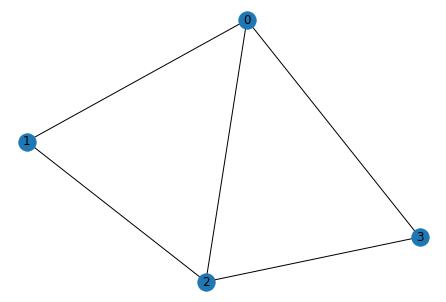

In [102]:
import cirq
import numpy as np
import math
from matplotlib import pyplot as plt
import random
from scipy.optimize import minimize
import networkx as nx
import scipy

# Defines the list of qubits

num = 4
depth = 4
rep = 1000
qubits = [cirq.GridQubit(0, i) for i in range(0, num)]

import networkx as nx
from matplotlib import pyplot as plt

class Graph:
    def __init__(self, edges_set):
        self.edges_set = edges_set
        self.node_set = []
        for i in edges_set:
            if (i.start_node not in self.node_set):
                self.node_set.append(i.start_node)
            if (i.end_node not in self.node_set):
                self.node_set.append(i.end_node)

class Edge:
    def __init__(self, start_node, end_node, weight=None):
        self.start_node = start_node
        self.end_node = end_node
        self.weight = weight
        # how to set a value of the object so when you print the object x shows up?

set_edges = [Edge(0,1,0.5), Edge(1,2,2), Edge(2,0,1.5), Edge(2,3,1.7), Edge(0,3,0.5)] # Define the graph here
# set_edges = [Edge(0, 1), Edge(1, 2), Edge(2, 3), Edge(3, 4)]

G = nx.Graph()

for z in set_edges:
    G.add_edge(str(z.start_node), str(z.end_node))

# G.add_weighted_edges_from(set_edges) # wait the graph doesn't NEED to have weights in it lol. you make the G variable only for the sake of drawing.

nx.draw(G, with_labels=True)
plt.savefig('graph.png')
# plt.clf() what does this fucntion do? read docs. well not v imp just for ur curiosity
plt.show()

# Defines the initialization

def initialization(qubits):
    for i in qubits:
        yield cirq.H.on(i)

In [103]:
# Defines the cost unitary

def cost_unitary(qubits, gamma):
    for i in set_edges:
        w = i.weight
        pauli_z = [[1, 0], [0, -1]]
        pauli_z_2 = np.kron(pauli_z, pauli_z)
        ZZPowGate = scipy.linalg.fractional_matrix_power(pauli_z_2, -1*w*gamma/math.pi)
        # yield cirq.ZZPowGate(exponent= -1*gamma/math.pi).on(qubits[i.start_node], qubits[i.end_node]) # zz pow gate seems to be equal to the np.kron product of 2 Z gates, then raised to an exponent. doesn't seem like there's an equivalent in pennylane. if i want to do it in pennylane i have to understand what a tensor product of 2 z gates raised to an exponent means.
        # I don't understand exponent -1/gamma/math.pi. like what the fuck??????? 
        # zzpowgate acts on 2 qubits
        ## in pennylane it was just RX(2 * beta, wires=edge[1]) so RX on 1 qubit
        # yup confirmed tensor product = kronecker product. tensor product is denoted by ⊗ OH okok nice
        # cirq uses zz powgate to measure 2 qubits in z basis aka find the expval of these 2 qubits in z basis.

        # coding it in pennylane if i understand why pavan's code works will demonstrate mastery.
        # solving circuit training 500 will demonstrate mastery of qml for classification. with cirq bc ik how to optimize in cirq.
        yield cirq.MatrixGate(ZZPowGate).on(qubits[i.start_node], qubits[i.end_node])

# Defines the mixer unitary

def mixer_unitary(qubits, alpha):
    for i in range(0, len(qubits)):
        yield cirq.XPowGate(exponent=-1*alpha/math.pi).on(qubits[i])

In [134]:
# Executes the circuit

def create_circuit(params):

    gamma = [params[0], params[2], params[4], params[6]]
    alpha = [params[1], params[3], params[5], params[7]]

    circuit = cirq.Circuit()
    circuit.append(initialization(qubits))
    for i in range(0, depth):
        circuit.append(cost_unitary(qubits, gamma[i]))
        circuit.append(mixer_unitary(qubits, alpha[i]))
    circuit.append(cirq.measure(*qubits, key='x'))
    # print(circuit)

    simulator = cirq.Simulator()
    results = simulator.run(circuit, repetitions=rep)
    # print(results)
    results = str(results)[2:].split(", ")
    # print("results")
    # print(results)
    new_res = []
    for i in range(0, rep):
        hold = []
        for j in range(0, num):
            hold.append(int(results[j][i]))
        new_res.append(hold)

    # print("new_res")
    # print(new_res)
    return new_res # res = result

In [138]:
# Defines the cost function

def cost_function(params):

    av = create_circuit(params)
    # res = create_circuit(params)
    total_cost = 0
    for i in range(0, len(av)):
        # print(f'len(av): {len(av)}')
        for j in set_edges:
            w = j.weight
            total_cost = total_cost + -1*(w*av[i][j.start_node]*(1-av[i][j.end_node]) + w*av[i][j.end_node]*(1-av[i][j.start_node]))
            unweighted_cost = 0.5*( ( (1 - 2*av[i][j.start_node]) * (1 - 2*av[i][j.end_node]) ) - 1)
            # weight = j.weight
            # weigted_cost = unweighted_cost * weight
            # total_cost += weigted_cost
            if j.weight == None:
                total_cost += unweighted_cost
#            else:
#                weight = j.weight
#                weigted_cost = unweighted_cost * weight
#                total_cost += weigted_cost
#                print(f'Weighted cost of edge {j}: {j.weight} x {unweighted_cost} = {weigted_cost}')
            
            
    total_cost = float(total_cost)/rep

    print("Cost: "+str(total_cost))

    return total_cost

Cost: -2.892599999999982
Cost: -3.0666999999999778
Cost: -2.6364999999999945
Cost: -2.189400000000006
Cost: -2.9002999999999814
Cost: -3.482599999999969
Cost: -2.435799999999998
Cost: -3.8387999999999427
Cost: -3.973899999999943
Cost: -3.547499999999958
Cost: -3.816199999999948
Cost: -3.632799999999954
Cost: -3.848299999999941
Cost: -3.957899999999943
Cost: -3.816099999999945
Cost: -3.246999999999971
Cost: -4.106699999999936
Cost: -4.147999999999933
Cost: -4.19949999999993
Cost: -4.07049999999993
Cost: -4.128299999999935
Cost: -4.0842999999999305
Cost: -4.130199999999934
Cost: -4.306599999999936
Cost: -3.8677999999999466
Cost: -4.118999999999942
Cost: -4.290499999999937
Cost: -4.125899999999939
Cost: -4.1267999999999505
Cost: -4.108599999999942
Cost: -4.292299999999933
Cost: -4.254499999999942
Cost: -4.073199999999943
Cost: -4.36339999999993
Cost: -4.355599999999936
Cost: -4.322799999999931
Cost: -4.472599999999928
Cost: -4.499499999999928
Cost: -4.402599999999931
Cost: -4.511899999999

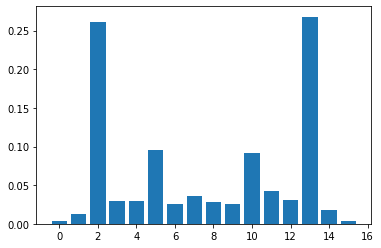

In [139]:
# Defines the optimization method

init =[float(random.randint(-314, 314))/float(100) for i in range(0, 8)]
out = minimize(cost_function, x0=init, method="COBYLA", options={'maxiter':100})
print(f'Out: {out}')

optimal_params = out['x']
f = create_circuit(optimal_params)

# Creates visualization of the optimal state

nums = []
freq = []

for i in range(0, len(f)):
    number = 0
    for j in range(0, len(f[i])):
        number += 2**(len(f[i])-j-1)*f[i][j]
    if (number in nums):
        freq[nums.index(number)] = freq[nums.index(number)] + 1
    else:
        nums.append(number)
        freq.append(1)

freq = [s/sum(freq) for s in freq]

print(nums)
print(freq)

x = range(0, 2**num)
y = []
for i in range(0, len(x)):
    if (i in nums):
        y.append(freq[nums.index(i)])
    else:
        y.append(0)

plt.bar(x, y)
plt.show()

In [ ]:
# yes my understanding of zzpowgate is correct!!!! qml.hermitian should work once i figure out other circuit structure shenanigans.